In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import joblib

In [3]:
df_full= pd.read_csv('Course_Completion_Prediction.csv')
df = df_full.sample(n=20000, random_state=42)

df.head()

,Student_ID,Name,Gender,Age,Education_Level,Employment_Status,City,Device_Type,Internet_Connection_Quality,Course_ID,...,Enrollment_Date,Payment_Mode,Fee_Paid,Discount_Used,Payment_Amount,App_Usage_Percentage,Reminder_Emails_Clicked,Support_Tickets_Raised,Satisfaction_Rating,Completed
75721,STU175721,Meera Reddy,Female,36,Bachelor,Employed,Hyderabad,Mobile,Low,C105,...,30-09-2025,NetBanking,Yes,No,4218,55,3,3,3.4,Completed
80184,STU180184,Sakshi Reddy,Male,30,Bachelor,Employed,Chennai,Mobile,High,C106,...,03-05-2025,UPI,Yes,No,6799,78,3,1,4.1,Completed
19864,STU119864,Ritika Iyer,Male,30,Bachelor,Self-Employed,Jaipur,Mobile,High,C101,...,22-05-2025,UPI,Yes,No,3877,34,8,1,4.7,Not Completed
76699,STU176699,Ananya Verma,Female,27,Master,Student,Chennai,Mobile,Medium,C105,...,05-07-2025,Free,No,No,0,96,3,0,4.0,Completed
92991,STU192991,Sakshi Mehta,Male,30,Bachelor,Student,Mumbai,Mobile,Medium,C103,...,09-07-2024,Credit Card,Yes,No,6112,17,0,1,5.0,Completed


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 75721 to 42410
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    20000 non-null  object 
 1   Name                          20000 non-null  object 
 2   Gender                        20000 non-null  object 
 3   Age                           20000 non-null  int64  
 4   Education_Level               20000 non-null  object 
 5   Employment_Status             20000 non-null  object 
 6   City                          20000 non-null  object 
 7   Device_Type                   20000 non-null  object 
 8   Internet_Connection_Quality   20000 non-null  object 
 9   Course_ID                     20000 non-null  object 
 10  Course_Name                   20000 non-null  object 
 11  Category                      20000 non-null  object 
 12  Course_Level                  20000 non-null  object 
 13  Co

In [5]:
df.isna().sum()

Student_ID                      0
Name                            0
Gender                          0
Age                             0
Education_Level                 0
Employment_Status               0
City                            0
Device_Type                     0
Internet_Connection_Quality     0
Course_ID                       0
Course_Name                     0
Category                        0
Course_Level                    0
Course_Duration_Days            0
Instructor_Rating               0
Login_Frequency                 0
Average_Session_Duration_Min    0
Video_Completion_Rate           0
Discussion_Participation        0
Time_Spent_Hours                0
Days_Since_Last_Login           0
Notifications_Checked           0
Peer_Interaction_Score          0
Assignments_Submitted           0
Assignments_Missed              0
Quiz_Attempts                   0
Quiz_Score_Avg                  0
Project_Grade                   0
Progress_Percentage             0
Rewatch_Count 

In [6]:
df = df.drop(["Student_ID", "Name", "Course_ID", "Enrollment_Date"], axis=1, errors='ignore')
df.shape

(20000, 36)

In [7]:
numb_cols = df.select_dtypes(include=[np.number]).columns.tolist()


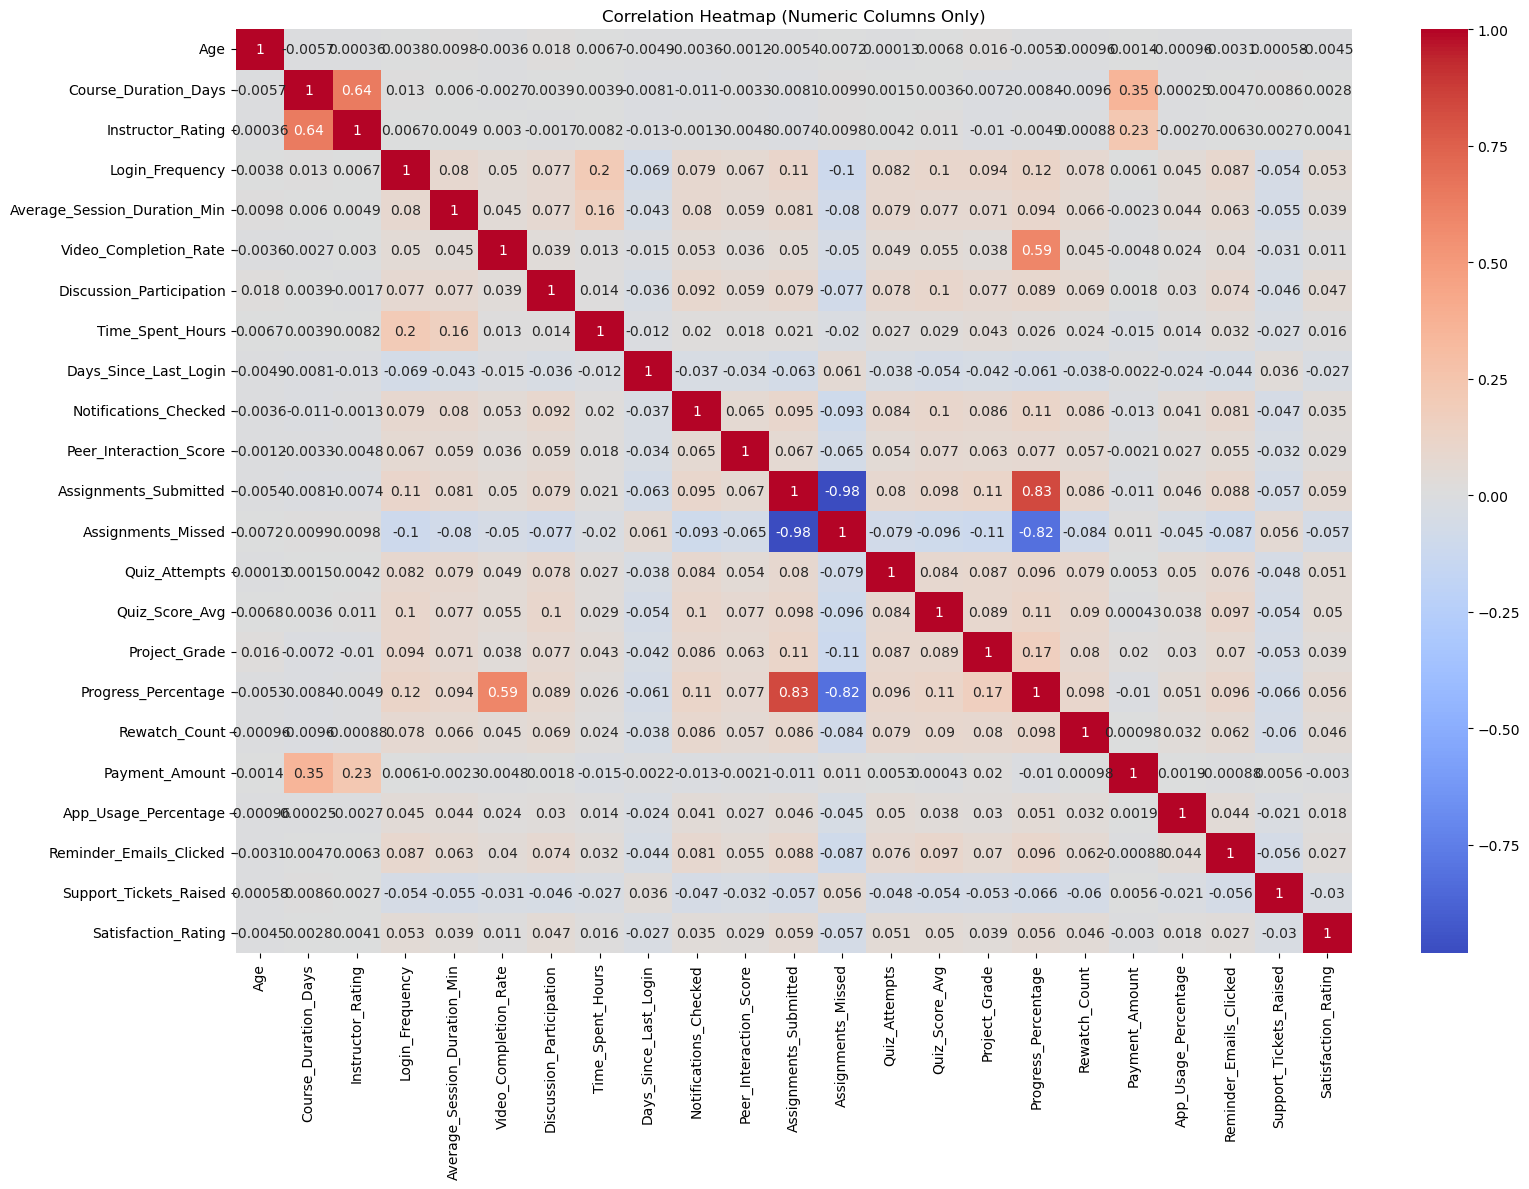

In [8]:
plt.figure(figsize=(18,12))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()

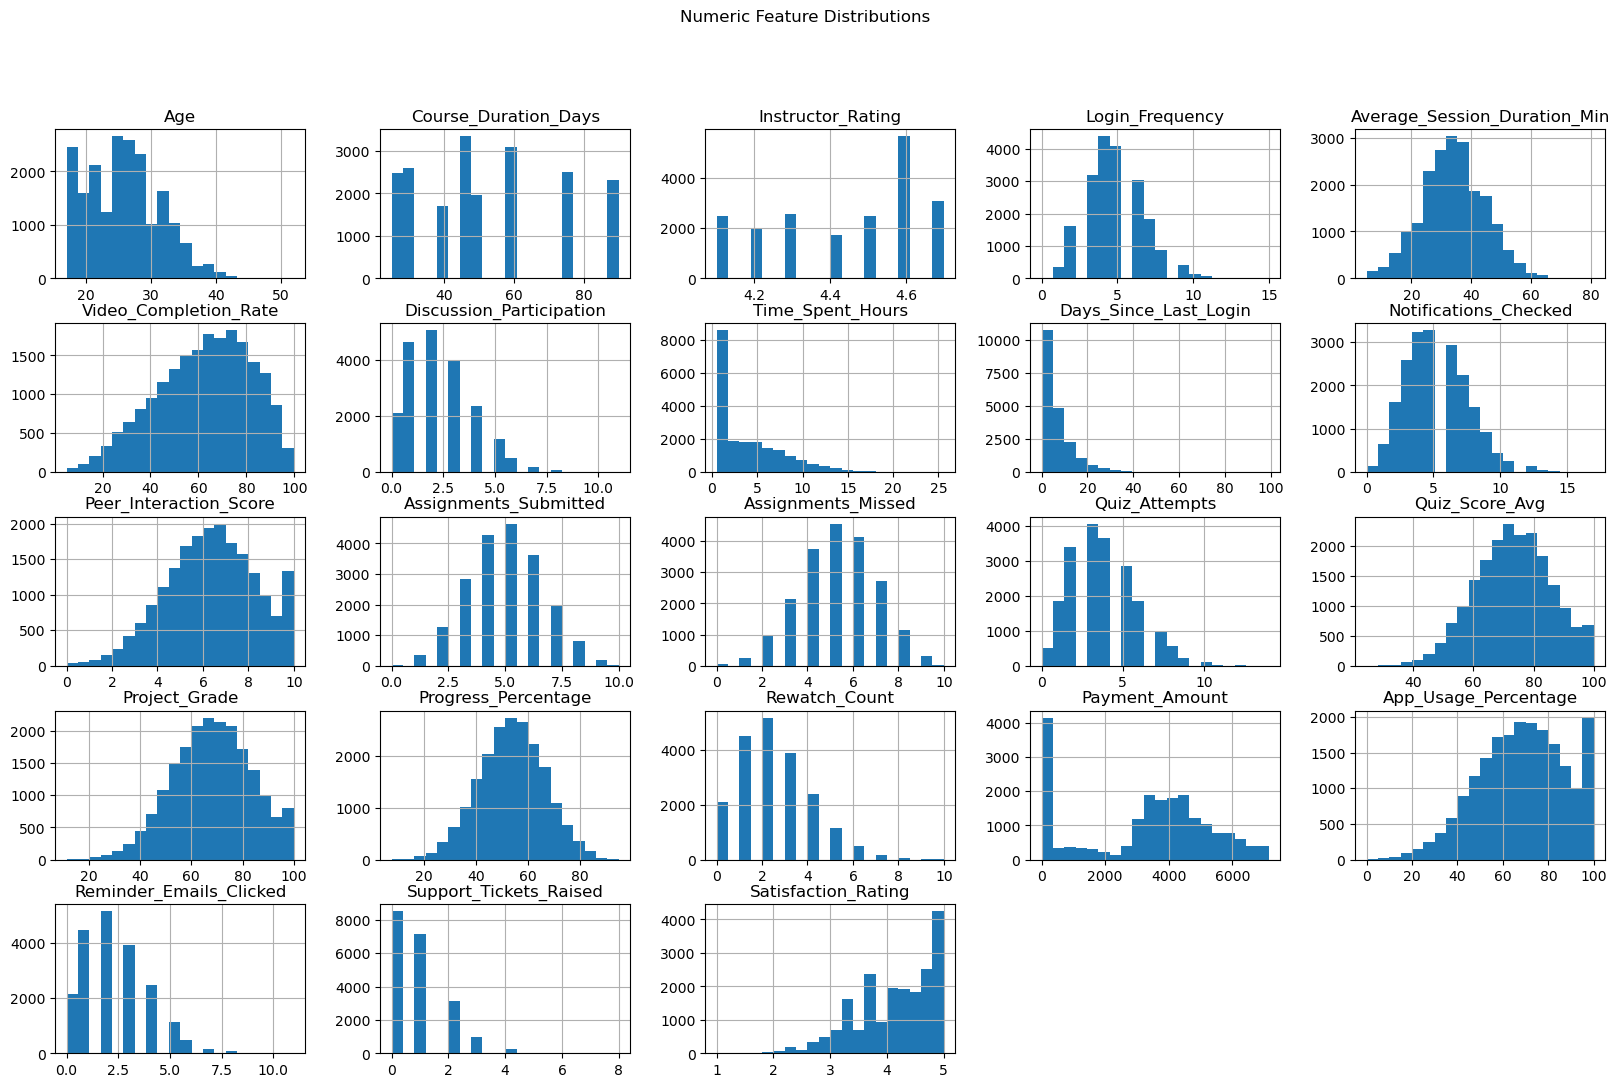

In [9]:
df.hist(figsize=(20,12), bins=20)
plt.suptitle("Numeric Feature Distributions")
plt.show()

In [8]:
df.shape

(20000, 36)

In [9]:
target_col = "Completed"   
y = df[target_col].copy()
y = y.astype(str).str.lower()
y = y.replace({
    "completed": 1,
    "not completed": 0,
})
y = y.astype(int)
print(y.value_counts())
X = df.drop([target_col], axis=1)

Completed
0    10138
1     9862
Name: count, dtype: int64


C:\Users\Pria Nandhini M A\AppData\Local\Temp\ipykernel_14692\2149070160.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({


In [10]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['Age', 'Course_Duration_Days', 'Instructor_Rating', 'Login_Frequency', 'Average_Session_Duration_Min', 'Video_Completion_Rate', 'Discussion_Participation', 'Time_Spent_Hours', 'Days_Since_Last_Login', 'Notifications_Checked', 'Peer_Interaction_Score', 'Assignments_Submitted', 'Assignments_Missed', 'Quiz_Attempts', 'Quiz_Score_Avg', 'Project_Grade', 'Progress_Percentage', 'Rewatch_Count', 'Payment_Amount', 'App_Usage_Percentage', 'Reminder_Emails_Clicked', 'Support_Tickets_Raised', 'Satisfaction_Rating']
Categorical columns: ['Gender', 'Education_Level', 'Employment_Status', 'City', 'Device_Type', 'Internet_Connection_Quality', 'Course_Name', 'Category', 'Course_Level', 'Payment_Mode', 'Fee_Paid', 'Discount_Used']


In [11]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [12]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

In [13]:
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")


In [14]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [15]:
X_train_proc = preprocessor.fit_transform(X_train_raw)
X_test_proc = preprocessor.transform(X_test_raw)

In [16]:
ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
ohe_feature_names = []
if len(cat_cols) > 0:
    ohe_feature_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = list(num_cols) + ohe_feature_names
print("Processed feature count:", len(feature_names))

Processed feature count: 82


In [17]:
X_train_df = pd.DataFrame(X_train_proc, columns=feature_names)
X_train_df['Completed'] = y_train.values
correlation = X_train_df.corr()['Completed'].sort_values(ascending=False)
print(correlation)

Completed                   1.000000
Progress_Percentage         0.211414
Video_Completion_Rate       0.168701
Assignments_Submitted       0.145535
Quiz_Score_Avg              0.085284
                              ...   
Payment_Mode_Scholarship   -0.026992
Days_Since_Last_Login      -0.046421
Payment_Mode_Free          -0.067421
Fee_Paid_No                -0.076499
Assignments_Missed         -0.144017
Name: Completed, Length: 83, dtype: float64


In [18]:
k = 50
k = min(k, X_train_proc.shape[1])
skb = SelectKBest(score_func=mutual_info_classif, k=k)
skb.fit(X_train_proc, y_train)
scores = skb.scores_
mi_series = pd.Series(scores, index=feature_names).sort_values(ascending=False)
display(mi_series.head(30))

Progress_Percentage                         0.027485
Video_Completion_Rate                       0.017438
Payment_Mode_Credit Card                    0.010593
Course_Name_Machine Learning A-Z            0.009042
Quiz_Score_Avg                              0.008938
Payment_Mode_UPI                            0.008875
Assignments_Submitted                       0.008601
Gender_Female                               0.008240
Category_Business                           0.008106
Course_Name_Digital Marketing Essentials    0.008040
Course_Level_Advanced                       0.006808
Course_Name_Data Analysis with Python       0.006718
City_Mumbai                                 0.006527
Assignments_Missed                          0.005913
Payment_Mode_NetBanking                     0.005824
Days_Since_Last_Login                       0.005714
Employment_Status_Student                   0.005666
Instructor_Rating                           0.004980
Average_Session_Duration_Min                0.

In [19]:
selected_indices_mi = skb.get_support(indices=True)
X_train_sel_mi = X_train_proc[:, selected_indices_mi]
X_test_sel_mi = X_test_proc[:, selected_indices_mi]


In [43]:
rf_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
n_features_rfe = 20
n_features_rfe = min(n_features_rfe, X_train_proc.shape[1])
rfe = RFE(estimator=rf_for_rfe, n_features_to_select=n_features_rfe, step=0.1)
rfe.fit(X_train_proc, y_train)
rfe_support = rfe.support_
rfe_selected_names = [feature_names[i] for i in range(len(feature_names)) if rfe_support[i]]
print("RFE selected features (count):", len(rfe_selected_names))
display(rfe_selected_names)

RFE selected features (count): 20


['Age',
 'Course_Duration_Days',
 'Instructor_Rating',
 'Login_Frequency',
 'Average_Session_Duration_Min',
 'Video_Completion_Rate',
 'Discussion_Participation',
 'Time_Spent_Hours',
 'Days_Since_Last_Login',
 'Notifications_Checked',
 'Peer_Interaction_Score',
 'Quiz_Attempts',
 'Quiz_Score_Avg',
 'Project_Grade',
 'Progress_Percentage',
 'Rewatch_Count',
 'Payment_Amount',
 'App_Usage_Percentage',
 'Reminder_Emails_Clicked',
 'Satisfaction_Rating']

In [46]:
selected_indices_rfe = [i for i, s in enumerate(rfe_support) if s]
X_train_sel_rfe = X_train_proc[:, selected_indices_rfe]
X_test_sel_rfe = X_test_proc[:, selected_indices_rfe]

In [47]:
logr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
svm = SVC(probability=True)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
gb = GradientBoostingClassifier(n_estimators=500, random_state=42)
xgb = XGBClassifier(eval_metric="logloss", n_estimators=500, random_state=42)
nb = GaussianNB()


In [48]:
logr.fit(X_train_sel_rfe, y_train)
pred_logr = logr.predict(X_test_sel_rfe)
prob_logr = logr.predict_proba(X_test_sel_rfe)[:,1]
acc_logr = accuracy_score(y_test, pred_logr)
prec_logr = precision_score(y_test, pred_logr, zero_division=0)
rec_logr = recall_score(y_test, pred_logr, zero_division=0)
f1_logr = f1_score(y_test, pred_logr, zero_division=0)
roc_logr = roc_auc_score(y_test, prob_logr)


In [49]:
print("Accuracy :", acc_logr)
print("Precision:", prec_logr)
print("Recall   :", rec_logr)
print("F1 Score :", f1_logr)
print("ROC AUC  :", roc_logr)

Accuracy : 0.60125
Precision: 0.5972150593089222
Recall   : 0.5872210953346856
F1 Score : 0.5921759140884684
ROC AUC  : 0.6471623438193886


In [50]:
knn.fit(X_train_sel_rfe, y_train)
pred_knn = knn.predict(X_test_sel_rfe)
prob_knn = knn.predict_proba(X_test_sel_rfe)[:,1]
acc_knn = accuracy_score(y_test, pred_knn)
prec_knn = precision_score(y_test, pred_knn, zero_division=0)
rec_knn = recall_score(y_test, pred_knn, zero_division=0)
f1_knn = f1_score(y_test, pred_knn, zero_division=0)
roc_knn = roc_auc_score(y_test, prob_knn)

In [51]:
print("Accuracy :", acc_knn)
print("Precision:", prec_knn)
print("Recall   :", rec_knn)
print("F1 Score :", f1_knn)
print("ROC AUC  :", roc_knn)

Accuracy : 0.55125
Precision: 0.5455481214616572
Recall   : 0.537525354969574
F1 Score : 0.541507024265645
ROC AUC  : 0.566092954219027


In [52]:
svm.fit(X_train_sel_rfe, y_train)
pred_svm = svm.predict(X_test_sel_rfe)
prob_svm = svm.predict_proba(X_test_sel_rfe)[:,1]
acc_svm = accuracy_score(y_test, pred_svm)
prec_svm = precision_score(y_test, pred_svm, zero_division=0)
rec_svm = recall_score(y_test, pred_svm, zero_division=0)
f1_svm = f1_score(y_test, pred_svm, zero_division=0)
roc_svm = roc_auc_score(y_test, prob_svm)

In [53]:
print("Accuracy :", acc_svm)
print("Precision:", prec_svm)
print("Recall   :", rec_svm)
print("F1 Score :", f1_svm)
print("ROC AUC  :", roc_svm)

Accuracy : 0.598
Precision: 0.5962962962962963
Recall   : 0.571501014198783
F1 Score : 0.5836354220611082
ROC AUC  : 0.626997891586751


In [54]:
dt.fit(X_train_sel_rfe, y_train)
pred_dt = dt.predict(X_test_sel_rfe)
prob_dt = dt.predict_proba(X_test_sel_rfe)[:,1]
acc_dt = accuracy_score(y_test, pred_dt)
prec_dt = precision_score(y_test, pred_dt, zero_division=0)
rec_dt = recall_score(y_test, pred_dt, zero_division=0)
f1_dt = f1_score(y_test, pred_dt, zero_division=0)
roc_dt = roc_auc_score(y_test, prob_dt)

In [55]:
print("Accuracy :", acc_dt)
print("Precision:", prec_dt)
print("Recall   :", rec_dt)
print("F1 Score :", f1_dt)
print("ROC AUC  :", roc_dt)

Accuracy : 0.526
Precision: 0.519211324570273
Recall   : 0.52079107505071
F1 Score : 0.52
ROC AUC  : 0.5259280819040533


In [56]:
rf.fit(X_train_sel_rfe, y_train)
pred_rf = rf.predict(X_test_sel_rfe)
prob_rf = rf.predict_proba(X_test_sel_rfe)[:,1]
acc_rf = accuracy_score(y_test, pred_rf)
prec_rf = precision_score(y_test, pred_rf, zero_division=0)
rec_rf = recall_score(y_test, pred_rf, zero_division=0)
f1_rf = f1_score(y_test, pred_rf, zero_division=0)
roc_rf = roc_auc_score(y_test, prob_rf)

In [57]:
print("Accuracy :", acc_rf)
print("Precision:", prec_rf)
print("Recall   :", rec_rf)
print("F1 Score :", f1_rf)
print("ROC AUC  :", roc_rf)

Accuracy : 0.598
Precision: 0.5966029723991507
Recall   : 0.5699797160243407
F1 Score : 0.58298755186722
ROC AUC  : 0.6357579835647786


In [58]:
gb.fit(X_train_sel_rfe, y_train)
pred_gb = gb.predict(X_test_sel_rfe)
prob_gb = gb.predict_proba(X_test_sel_rfe)[:,1]
acc_gb = accuracy_score(y_test, pred_gb)
prec_gb = precision_score(y_test, pred_gb, zero_division=0)
rec_gb = recall_score(y_test, pred_gb, zero_division=0)
f1_gb = f1_score(y_test, pred_gb, zero_division=0)
roc_gb = roc_auc_score(y_test, prob_gb)

In [59]:
print("Accuracy :", acc_gb)
print("Precision:", prec_gb)
print("Recall   :", rec_gb)
print("F1 Score :", f1_gb)
print("ROC AUC  :", roc_gb)

Accuracy : 0.58375
Precision: 0.5803244374672946
Recall   : 0.5623732251521298
F1 Score : 0.5712078289981972
ROC AUC  : 0.6166878708226813


In [60]:
xgb.fit(X_train_sel_rfe, y_train)
pred_xgb = xgb.predict(X_test_sel_rfe)
prob_xgb = xgb.predict_proba(X_test_sel_rfe)[:,1]
acc_xgb = accuracy_score(y_test, pred_xgb)
prec_xgb = precision_score(y_test, pred_xgb, zero_division=0)
rec_xgb = recall_score(y_test, pred_xgb, zero_division=0)
f1_xgb = f1_score(y_test, pred_xgb, zero_division=0)
roc_xgb = roc_auc_score(y_test, prob_xgb)

In [61]:
print("Accuracy :", acc_xgb)
print("Precision:", prec_xgb)
print("Recall   :", rec_xgb)
print("F1 Score :", f1_xgb)
print("ROC AUC  :", roc_xgb)

Accuracy : 0.55475
Precision: 0.549869451697128
Recall   : 0.533975659229209
F1 Score : 0.5418060200668896
ROC AUC  : 0.5774099223447796


In [62]:
nb.fit(X_train_sel_rfe, y_train)
pred_nb = nb.predict(X_test_sel_rfe)
prob_nb = nb.predict_proba(X_test_sel_rfe)[:,1]
acc_nb = accuracy_score(y_test, pred_nb)
prec_nb = precision_score(y_test, pred_nb, zero_division=0)
rec_nb = recall_score(y_test, pred_nb, zero_division=0)
f1_nb = f1_score(y_test, pred_nb, zero_division=0)
roc_nb = roc_auc_score(y_test, prob_nb)

print("Naive Bayes Metrics:")
print("Accuracy :", acc_nb)
print("Precision:", prec_nb)
print("Recall   :", rec_nb)
print("F1 Score :", f1_nb)
print("ROC AUC  :", roc_nb)

Naive Bayes Metrics:
Accuracy : 0.604
Precision: 0.5949119373776908
Recall   : 0.6166328600405679
F1 Score : 0.6055776892430279
ROC AUC  : 0.6369430908458058


In [63]:
results = pd.DataFrame({
    "Model": [
        "LogisticRegression","KNN","SVM","DecisionTree","RandomForest",
        "GradientBoosting","XGBoost","NaiveBayes"
    ],
    "Accuracy": [
        acc_logr, acc_knn, acc_svm, acc_dt, acc_rf, acc_gb, acc_xgb, acc_nb
    ],
    "Precision": [
        prec_logr, prec_knn, prec_svm, prec_dt, prec_rf, prec_gb, prec_xgb, prec_nb
    ],
    "Recall": [
        rec_logr, rec_knn, rec_svm, rec_dt, rec_rf, rec_gb, rec_xgb, rec_nb
    ],
    "F1": [
        f1_logr, f1_knn, f1_svm, f1_dt, f1_rf, f1_gb, f1_xgb, f1_nb
    ],
    "ROC_AUC": [
        roc_logr, roc_knn, roc_svm, roc_dt, roc_rf, roc_gb, roc_xgb, roc_nb
    ]
})
display(results.sort_values(by="Accuracy", ascending=False))

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
7,NaiveBayes,0.60400,0.594912,0.616633,0.605578,0.636943
0,LogisticRegression,0.60125,0.597215,0.587221,0.592176,0.647162
2,SVM,0.59800,0.596296,0.571501,0.583635,0.626998
4,RandomForest,0.59800,0.596603,0.569980,0.582988,0.635758
5,GradientBoosting,0.58375,0.580324,0.562373,0.571208,0.616688
6,XGBoost,0.55475,0.549869,0.533976,0.541806,0.577410
1,KNN,0.55125,0.545548,0.537525,0.541507,0.566093
3,DecisionTree,0.52600,0.519211,0.520791,0.520000,0.525928


In [64]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}
gscv = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                    param_grid, scoring="f1", cv=3, n_jobs=-1, verbose=1)
gscv.fit(X_train_sel_rfe, y_train)
best_rf = gscv.best_estimator_
print("Best RF params:", gscv.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best RF params: {'max_depth': 10, 'n_estimators': 200}


In [65]:
pred_best_rf = best_rf.predict(X_test_sel_rfe)
prob_best_rf = best_rf.predict_proba(X_test_sel_rfe)[:,1]
print("Best RF Test F1:", f1_score(y_test, pred_best_rf, zero_division=0))
print("Classification report (best RF):")
print(classification_report(y_test, pred_best_rf))

Best RF Test F1: 0.5901806156194352
Classification report (best RF):
              precision    recall  f1-score   support

           0       0.60      0.61      0.60      2028
           1       0.59      0.59      0.59      1972

    accuracy                           0.60      4000
   macro avg       0.60      0.60      0.60      4000
weighted avg       0.60      0.60      0.60      4000



In [66]:
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(selected_indices_rfe, "rfe_indices.pkl")
joblib.dump(best_rf, "best_random_forest.pkl")


['best_random_forest.pkl']